# 라이브러리 임포트

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re


import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 데이터 불러오기 및 전처리


In [3]:
image_path = "C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/"
dir_labelling = pd.read_csv("C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/label/pepper_disease_normal.csv", encoding='cp949').drop('Unnamed: 0', axis=1)

In [4]:
dir_labelling.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다


In [5]:
ls = os.listdir(image_path)
len([f for f in ls if '.npy' not in f]) #고추이미지 총 개수

24795

# 4개의 이미지에 대해, 각 이미지에 5개씩 대응되는 라벨 문장 출력해보기

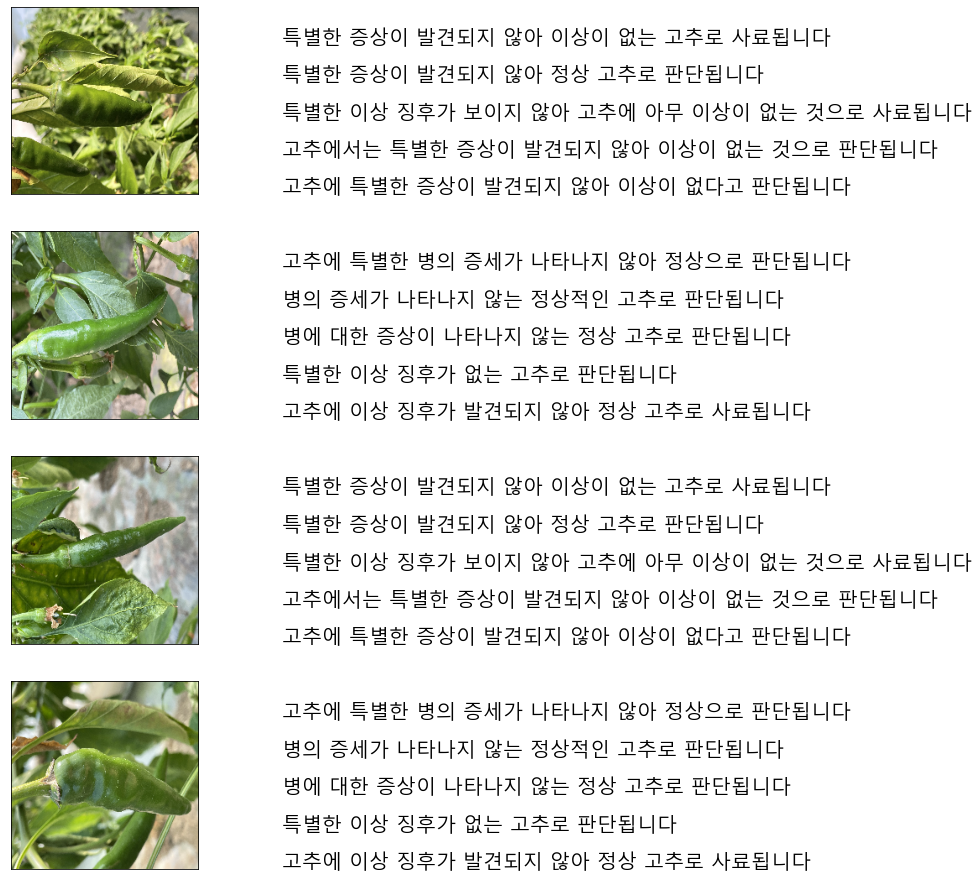

In [6]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in np.unique(dir_labelling['images'])[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(dir_labelling["captions"].loc[dir_labelling["images"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

# Vocabulary size 확인

In [7]:
vocabulary = []
for text in dir_labelling.captions.values:
  vocabulary.extend(text.split()) #토크나이징을 공백(띄어쓰기) 기준으로 수행(나중에 형태소단위로 토크나이징 시도해볼 수 있음)

vocabulary = list(set(vocabulary))
print(f'vocabulary 사이즈는 {len(vocabulary)} 입니다.')

vocabulary 사이즈는 94 입니다.


In [8]:
vocabulary[:15]

['들어나는',
 '반점과',
 '비틀어지고',
 '증세가',
 '움푹',
 '것으로',
 '생긴',
 '얇은',
 '고추에서',
 '고추가',
 '고춧잎에서',
 '비틀어진',
 '포자덩어리와',
 '같은',
 '병에']

# 텍스트 전처리(일단 안함)
- 문장 라벨 만들때 전처리 안 해도 되도록 기준 설정해둠.

# 문장에 \<start>, \<end> 토큰 부착하기

In [9]:
attached_captions = []
for caption in dir_labelling['captions']:
  caption = '<start> ' + caption + ' <end>'
  attached_captions.append(caption)

In [10]:
attached_captions[:10]

['<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다 <end>']

# 이미지 전체 경로 리스트(중복포함임)

In [11]:
all_img_name_vector = []
for file in dir_labelling['images']:
  full_img_path = image_path + file
  all_img_name_vector.append(full_img_path)

all_img_name_vector[:7]

['C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG',
 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/project_dataset/project_dataset/train/pepper_images/V006_79_1_01_01_01_13_1_0149z_20201007_2.JPG',
 'C:

In [12]:
print(f'전체 이미지 경로 개수(all_img_name_vector) : {len(all_img_name_vector)}\n전체 캡션 개수(attached_captions) : {len(attached_captions)}')

전체 이미지 경로 개수(all_img_name_vector) : 120815
전체 캡션 개수(attached_captions) : 120815


# 이미지 특징 추출하는 모델(이미지 캡셔닝 모델의 인코더 부분) 정의하기

In [13]:
#이미지 읽어오는 함수
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #ResNet101로 이미지 특징 추출
new_input = image_model.input
hidden_layer = image_model.layers[-1].output #이미지 분류를 하지 않으므로 마지막 layer인 softmax 층을 제거함. 즉, 이미지에서 특징만 추출

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#이미지 특징 추출 모델


In [14]:
#개수가 같은 전체 캡션 개수 배열(array)과 전체 이미지 이름 배열에 대해 일관된 순서로 데이터를 섞는다.
#두 배열에서 같은 행 인덱스에 있던 값은 데이터가 섞인 뒤에도 서로 같은 위치에 있다.
train_captions, img_name_vector = shuffle(attached_captions, all_img_name_vector, random_state=1)

### 이미지를 읽어오기 위해 이미지를 읽어오는 함수(load_image)에 각 이미지 이름을 대응(map)시킨다.

In [15]:
encoded_train = sorted(set(img_name_vector)) #집합으로 변환하는 이유: 코드 처리 속도 빠르게 하기 위해서, 중복없는 이미지만 있게 하려고(혹시 모르니까)
image_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

### 이미지에서 특징을 추출하고, 각 특징을 넘파이 형식의 파일(.npy)로 변환하여 저장한다. 이후 이 넘파이 형식의 파일은 인코더에 입력된다.
- 넘파이 형식의 파일은 자료형과 행렬크기정보  등 어느 컴퓨터에나 배열(array)을 재구성하는데 필요한 모든 정보를 저장한다.

In [16]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 1511/1511 [05:03<00:00,  4.98it/s]


# 캡션 전처리 및 토큰화
- 캡션을 토크나이징하여 중복 없는 단어들로 구성된 사전을 구축한다
- 구두점은 모두 제거함
- 혹시 사전에 없는 단어가 있으면 해당 단어는 \<unk> 토큰으로 대체함
- 그 후 각 단어에 인덱스를 부여하고, 단어:인덱스 형식으로 변형한다.
- 모델 학습을 위해 모든 문장의 길이를 맞춰줘야 하는데 이를 위해 모든 문장(시퀀스)를 가장 길이가 긴 문장의 길이에 맞춘다. 길이는 0으로 padding하여 맞춘다.

In [16]:
#토크나이저 생성
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token = '<unk>',
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [17]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
print(train_seqs[:10])

[[2, 7, 16, 21, 22, 24, 11, 25, 48, 12, 13, 6, 5, 8, 4, 3], [2, 7, 16, 21, 22, 24, 11, 25, 48, 12, 13, 6, 5, 8, 4, 3], [2, 7, 11, 30, 17, 28, 14, 12, 13, 42, 5, 8, 4, 3], [2, 33, 57, 58, 52, 56, 35, 3], [2, 16, 29, 14, 39, 47, 6, 5, 8, 4, 3], [2, 7, 26, 10, 43, 15, 9, 4, 3], [2, 33, 57, 58, 76, 34, 70, 77, 51, 52, 6, 20, 3], [2, 50, 12, 62, 53, 17, 28, 15, 8, 20, 3], [2, 70, 33, 40, 46, 34, 51, 78, 35, 3], [2, 26, 36, 18, 31, 32, 41, 71, 10, 43, 19, 6, 5, 9, 20, 3]]


In [18]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [19]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '사료됩니다': 20, '포자덩어리와': 21, '움푹': 22, '병무늬가': 23, '들어간': 24, '반점이': 25, '잎에': 26, '포자와': 27, '포자덩어리가': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '특별한': 33, '않아': 34, '판단됩니다': 35, '이슬과': 36, '서릿발': 37, '모양의': 38, '원형반점이': 39, '증상이': 40, '곰팡이가': 41, '것을': 42, '반점무늬가': 43, '바른': 44, '것과': 45, '발견되지': 46, '생긴': 47, '나타나며': 48, '넓게': 49, '고추가': 50, '이상이': 51, '없는': 52, '원형반점과': 53, '밀가루를': 54, '얇은': 55, '고춧잎으로': 56, '이상': 57, '징후가': 58, '정상': 59, '나타나지': 60, '고추로': 61, '비틀어지고': 62, '보여': 63, '말라비틀어진': 64, '고추탄저병이': 65, '곰팡이와': 66, '병의': 67, '증세가': 68, '않는': 69, '고춧잎에': 70, '보이고': 71, '병무늬와': 72, '밀가루': 73, '반점무늬와': 74, '생겼고': 75, '보이지': 76, '아무': 77, '없다고': 78, '정상으로': 79, '정상적인': 80, '병에': 81, '대한': 82, '보이는': 83, '발견되므로': 84, '고춧잎에서': 85, '고추에서는': 86, '곳으로': 87, '고추에서'

In [20]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '의심됩니다', 5: '보아', 6: '것으로', 7: '고추에', 8: '고추탄저병으로', 9: '고추흰가루병으로', 10: '담황색', 11: '원형', 12: '말라', 13: '비틀어진', 14: '나타나고', 15: '발견되어', 16: '황갈색의', 17: '황갈색', 18: '같은', 19: '나타나는', 20: '사료됩니다', 21: '포자덩어리와', 22: '움푹', 23: '병무늬가', 24: '들어간', 25: '반점이', 26: '잎에', 27: '포자와', 28: '포자덩어리가', 29: '포자가', 30: '반점과', 31: '연한', 32: '흰색', 33: '특별한', 34: '않아', 35: '판단됩니다', 36: '이슬과', 37: '서릿발', 38: '모양의', 39: '원형반점이', 40: '증상이', 41: '곰팡이가', 42: '것을', 43: '반점무늬가', 44: '바른', 45: '것과', 46: '발견되지', 47: '생긴', 48: '나타나며', 49: '넓게', 50: '고추가', 51: '이상이', 52: '없는', 53: '원형반점과', 54: '밀가루를', 55: '얇은', 56: '고춧잎으로', 57: '이상', 58: '징후가', 59: '정상', 60: '나타나지', 61: '고추로', 62: '비틀어지고', 63: '보여', 64: '말라비틀어진', 65: '고추탄저병이', 66: '곰팡이와', 67: '병의', 68: '증세가', 69: '않는', 70: '고춧잎에', 71: '보이고', 72: '병무늬와', 73: '밀가루', 74: '반점무늬와', 75: '생겼고', 76: '보이지', 77: '아무', 78: '없다고', 79: '정상으로', 80: '정상적인', 81: '병에', 82: '대한', 83: '보이는', 84: '발견되므로', 85: '고춧잎에서', 86: '고추에서는', 87: '곳으로', 88: '고

In [21]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector =  tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [22]:
cap_vector[:5]

array([[ 2,  7, 16, 21, 22, 24, 11, 25, 48, 12, 13,  6,  5,  8,  4,  3],
       [ 2,  7, 16, 21, 22, 24, 11, 25, 48, 12, 13,  6,  5,  8,  4,  3],
       [ 2,  7, 11, 30, 17, 28, 14, 12, 13, 42,  5,  8,  4,  3,  0,  0],
       [ 2, 33, 57, 58, 52, 56, 35,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 16, 29, 14, 39, 47,  6,  5,  8,  4,  3,  0,  0,  0,  0,  0]])

In [23]:
cap_vector.shape

(120815, 16)

### 훈련, 검증데이터를 80:20 비율로 나누기

In [24]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(96652, 96652, 24163, 24163)

### 모델 훈련에 사용하기 위해 텐서플로우의 data.dataset을 생성 (tf.data.dataset)

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   
   img_tensor = np.load(img_name.decode("utf-8")+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 트랜스포머 모델 만들기(이미지 캡셔닝 모델의 디코더 부분)★★★

### positional encoding (입력 토큰의 문장에서의 위치 정보를 알려줌)
- 입력 벡터의 인덱스가 홀수면 코사인함수를 이용하여 위치 벡터를 생성하고 입력 벡터의 인덱스가 짝수면 사인함수를 이용하여 위치 벡터를 생성함.
- 그 다음 각 위치 벡터를 해당 벡터에 대응되는 입력 벡터에 더한다.

In [27]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
   #짝수 인덱스에는 사인함수를 적용 
   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   #홀수 인덱스에는 코사인 함수를 적용
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   
   pos_encoding = angle_rads[np.newaxis, ...]
   
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0

   # 첫번째 d_model/2는 행 임베딩을 인코딩하고 두번째 d_model/2는 열 임베딩을 인코딩한다.
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   # apply sin and cos to odd and even indices resp.
   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

### Multi-Head Attention
- self attention 층을 여러 겹 쌓은 것을 Multi-Head Attention이라고 부른다.
- query(q), key(k), value(v) 벡터를 생성하는데, k와 v의 길이는 같아야 한다. 나중에 어텐션 스코어를 구할 때 두 벡터를 내적하여 하나의 스칼라 값을 구하기 때문이다.


In [28]:
#패드 토큰 마스킹하기 - 패딩한 토큰을 모델이 입력으로 취급하지 않도록 한다.
#위에서 0으로 패딩된 패드 토큰은 1을 출력하고 나머지 토큰은 0을 출력하도록 함수를 생성함.
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#look ahead mask를 생성. look ahead mask는 모델의 학습을 위해 전체 시퀀스에서 현재 예측해야 하는 시퀀스부터 미래에 예측해야 하는 시퀀스까지 모두 마스킹하는 것.
#예를 들어 세 번째 토큰을 예측하기 위해 첫번째, 두번째 토큰만 사용하고 세번째 토큰부터는 마스킹하는 것.
def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

#query, key, value로 attention weight를 계산하는데, query와 key를 내적하여 나온 스칼라 값(attention score)에 key의 차원 수(dk)의 제곱근을 나눠주어 스칼라값을 스케일링 해준다.
#스케일링 하는 이유: key의 차원이 커질수록 query와 key에 대한 내적 계산시 내적된 값이 커지는 문제를 보완하기 위해 수행.
def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  #마스킹되는 위치에 절댓값이 매우 작은 음수 값을 넣는다(-0.000000001)
  #나중에 소프트맥스 함수를 거치면 이 마스킹된 위치의 값은 거의 0으로 수렴한다.
   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

#Multi-Head Attention : 어텐션을 여러번 병렬로 처리한다.
class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
      # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights


### Point-Wise Feed Forward Neural Network

- 두 개의 완전 연결된 층(layer)으로 구성된 네트워크로, 활성화 함수로는 ReLU함수를 사용한다.
- 트랜스포머 모델에서의 인코더 구조, 디코더 구조 모두에 공통적으로 가지고 있다.

In [29]:
def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
                ])

### 트랜스포머의 인코더 구조 정의

In [30]:
#인코더 층(layer)을 정의하기
  #<구성 요소>
  # 패딩 마스크가 포함된 Multi-Head Attention
  # Point-Wise Feed Forward Neural Network

class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      #층 정규화(layer normalization)
      #모델 학습을 돕기 위해 텐서의 마지막 차원에 대한 평균과 분산을 구하고 평균, 분산값을 이용한 수식으로 값을 정규화하는 과정
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      #드롭아웃(Drop Out)
      #과대적합(Overfitting)을 방지하기 위해 rate의 확률로 뉴런을 제거하는 기법
      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      #잔차 연결(x + attn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      #잔차 연결(out1 + ffn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2


#인코더 구조를 정의하기
  #<구성 요소>
  # 입력 임베딩 벡터
  # 위치 인코딩
  # N개의 인코더 층

class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size, rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                          for _ in range(num_layers)]
      
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

### 트랜스포머 모델의 디코더 구조 정의

In [31]:
#디코더 층(layer)을 정의하기
  #<구성 요소>
  # look-ahead 마스크와 패딩 마스크가 포함된 Masked Multi-Head Attention
  # 패딩 마스크가 포함된 Multi-Head Attention. Key, Value는 인코더의 결과물을 입력값으로 받고, Query는 Masked Multi-Head Attention 층의 결과물을 입력값으로 받는다.
  # Point-Wise Feed Forward Neural Network

class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None): # enc_output.shape == (batch_size, input_seq_len, d_model)
      
      # self-attention 진행 중에 현재의 query가 미래의 token을 고려하지 않도록 하기 위해 look-ahead mask를 사용함
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      # 인코더 출력값의 패딩된 값과 디코더 입력값의 패딩된 값을 피하기 위해 padding mask를 사용한다
      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2


#디코더 구조를 정의하기
  #<구성 요소>
  # 출력 임베딩 벡터
  # 위치 인코딩
  # N개의 디코더 층

class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding, rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
      # x.shape == (batch_size, target_seq_len, d_model)
      return x, attention_weights

## 트랜스포머 모델 구축하기
- 인코더 구조, 디코더 구조, 마지막 선형 층으로 구성된다.
- 디코더의 출력 결과는 선형 층의 입력값으로 들어가고, 이렇게 해서 생성된 최종 결과물이 반환된다.

In [32]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

## 트랜스포머 모델 훈련을 위한 초매개변수(Hyperparameters) 설정하기

In [33]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [34]:
#커스터마이징한 학습률 스케줄러 생성
#'Attention is all you need' 논문 즉, Transformer 모델을 소개한 이 논문에서 사용한 학습률 스케줄러를 생성함.
#학습률 스케줄러의 역할: 모델 학습과정에서 미리 학습 일정을 정해두고 그 일정에 따라 학습률을 동적으로 변경해줌

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [35]:
#학습률, 옵티마이저, 손실함수 정의하기
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)

   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [36]:
#훈련 오차 및 정확도 선언
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

#트랜스포머 모델 선언
transformer = Transformer(num_layer,
                          d_model,
                          num_heads,
                          dff,
                          row_size,
                          col_size,
                          target_vocab_size, 
                          max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

# 모델 훈련
- 이미지에서 추출된 특징이 담겨있는 .npy 파일과 정답 라벨 문장(타겟 문장)을 트랜스포머 모델에 입력하면 그 이미지에 대한 예상 문장(캡션)을 출력함.
- 결과에 대한 loss 및 그레이디언트 계산 후 loss가 최소가 되도록 훈련을 반복함

In [37]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [38]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]

   dec_mask = create_masks_decoder(tar_inp)

   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [39]:
print()

In [40]:
for epoch in tqdm(range(30)): #에포크 설정 - 20/30/등등... 동인 프로토타입은 20으로 설정됨. 내가 참고한 코드에선 30으로 설정됨
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      
      if batch % 50 == 0:
         print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 9.2890 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8469 Accuracy 0.0369
Epoch 1 Batch 100 Loss 8.3585 Accuracy 0.0516
Epoch 1 Batch 150 Loss 7.7911 Accuracy 0.0868
Epoch 1 Batch 200 Loss 7.0536 Accuracy 0.1637
Epoch 1 Batch 250 Loss 6.2869 Accuracy 0.2311
Epoch 1 Batch 300 Loss 5.5638 Accuracy 0.2869
Epoch 1 Batch 350 Loss 4.9360 Accuracy 0.3331
Epoch 1 Batch 400 Loss 4.4105 Accuracy 0.3718
Epoch 1 Batch 450 Loss 3.9793 Accuracy 0.4024
Epoch 1 Batch 500 Loss 3.6248 Accuracy 0.4272
Epoch 1 Batch 550 Loss 3.3294 Accuracy 0.4481
Epoch 1 Batch 600 Loss 3.0807 Accuracy 0.4652
Epoch 1 Batch 650 Loss 2.8687 Accuracy 0.4800
Epoch 1 Batch 700 Loss 2.6859 Accuracy 0.4929
Epoch 1 Batch 750 Loss 2.5286 Accuracy 0.5035
Epoch 1 Batch 800 Loss 2.3886 Accuracy 0.5136
Epoch 1 Batch 850 Loss 2.2654 Accuracy 0.5222
Epoch 1 Batch 900 Loss 2.1554 Accuracy 0.5297
Epoch 1 Batch 950 Loss 2.0571 Accuracy 0.5368
Epoch 1 Batch 1000 Loss 1.9684 Accuracy 0.5431
Epoch 1 Batch 1050 Loss 1.8881 Accur

  3%|██▋                                                                             | 1/30 [03:29<1:41:21, 209.71s/it]

Epoch 1 Loss 1.3965 Accuracy 0.5825
Time taken for 1 epoch: 209.71228957176208 secs

Epoch 2 Batch 0 Loss 0.2548 Accuracy 0.6802
Epoch 2 Batch 50 Loss 0.2643 Accuracy 0.6667
Epoch 2 Batch 100 Loss 0.2667 Accuracy 0.6643
Epoch 2 Batch 150 Loss 0.2672 Accuracy 0.6621
Epoch 2 Batch 200 Loss 0.2671 Accuracy 0.6630
Epoch 2 Batch 250 Loss 0.2663 Accuracy 0.6638
Epoch 2 Batch 300 Loss 0.2668 Accuracy 0.6629
Epoch 2 Batch 350 Loss 0.2664 Accuracy 0.6626
Epoch 2 Batch 400 Loss 0.2663 Accuracy 0.6631
Epoch 2 Batch 450 Loss 0.2664 Accuracy 0.6633
Epoch 2 Batch 500 Loss 0.2664 Accuracy 0.6636
Epoch 2 Batch 550 Loss 0.2663 Accuracy 0.6635
Epoch 2 Batch 600 Loss 0.2666 Accuracy 0.6628
Epoch 2 Batch 650 Loss 0.2664 Accuracy 0.6631
Epoch 2 Batch 700 Loss 0.2669 Accuracy 0.6631
Epoch 2 Batch 750 Loss 0.2665 Accuracy 0.6631
Epoch 2 Batch 800 Loss 0.2661 Accuracy 0.6634
Epoch 2 Batch 850 Loss 0.2659 Accuracy 0.6633
Epoch 2 Batch 900 Loss 0.2659 Accuracy 0.6633
Epoch 2 Batch 950 Loss 0.2660 Accuracy 0.663

  7%|█████▎                                                                          | 2/30 [06:51<1:35:34, 204.79s/it]

Epoch 2 Loss 0.2695 Accuracy 0.6626
Time taken for 1 epoch: 201.33629941940308 secs

Epoch 3 Batch 0 Loss 0.2536 Accuracy 0.6979
Epoch 3 Batch 50 Loss 0.2836 Accuracy 0.6619
Epoch 3 Batch 100 Loss 0.2845 Accuracy 0.6608
Epoch 3 Batch 150 Loss 0.2875 Accuracy 0.6599
Epoch 3 Batch 200 Loss 0.2908 Accuracy 0.6594
Epoch 3 Batch 250 Loss 0.2895 Accuracy 0.6593
Epoch 3 Batch 300 Loss 0.2886 Accuracy 0.6593
Epoch 3 Batch 350 Loss 0.2881 Accuracy 0.6588
Epoch 3 Batch 400 Loss 0.2873 Accuracy 0.6597
Epoch 3 Batch 450 Loss 0.2876 Accuracy 0.6596
Epoch 3 Batch 500 Loss 0.2876 Accuracy 0.6597
Epoch 3 Batch 550 Loss 0.2879 Accuracy 0.6596
Epoch 3 Batch 600 Loss 0.2879 Accuracy 0.6596
Epoch 3 Batch 650 Loss 0.2874 Accuracy 0.6596
Epoch 3 Batch 700 Loss 0.2870 Accuracy 0.6600
Epoch 3 Batch 750 Loss 0.2867 Accuracy 0.6600
Epoch 3 Batch 800 Loss 0.2865 Accuracy 0.6601
Epoch 3 Batch 850 Loss 0.2864 Accuracy 0.6601
Epoch 3 Batch 900 Loss 0.2870 Accuracy 0.6600
Epoch 3 Batch 950 Loss 0.2866 Accuracy 0.660

 10%|████████                                                                        | 3/30 [10:15<1:32:01, 204.51s/it]

Epoch 3 Loss 0.2895 Accuracy 0.6592
Time taken for 1 epoch: 204.17598009109497 secs

Epoch 4 Batch 0 Loss 0.2731 Accuracy 0.6750
Epoch 4 Batch 50 Loss 0.2967 Accuracy 0.6617
Epoch 4 Batch 100 Loss 0.2955 Accuracy 0.6583
Epoch 4 Batch 150 Loss 0.2915 Accuracy 0.6581
Epoch 4 Batch 200 Loss 0.2873 Accuracy 0.6592
Epoch 4 Batch 250 Loss 0.2860 Accuracy 0.6590
Epoch 4 Batch 300 Loss 0.2863 Accuracy 0.6587
Epoch 4 Batch 350 Loss 0.2866 Accuracy 0.6583
Epoch 4 Batch 400 Loss 0.2854 Accuracy 0.6588
Epoch 4 Batch 450 Loss 0.2845 Accuracy 0.6592
Epoch 4 Batch 500 Loss 0.2830 Accuracy 0.6597
Epoch 4 Batch 550 Loss 0.2825 Accuracy 0.6596
Epoch 4 Batch 600 Loss 0.2825 Accuracy 0.6597
Epoch 4 Batch 650 Loss 0.2810 Accuracy 0.6602
Epoch 4 Batch 700 Loss 0.2809 Accuracy 0.6606
Epoch 4 Batch 750 Loss 0.2820 Accuracy 0.6601
Epoch 4 Batch 800 Loss 0.2824 Accuracy 0.6601
Epoch 4 Batch 850 Loss 0.2827 Accuracy 0.6601
Epoch 4 Batch 900 Loss 0.2831 Accuracy 0.6600
Epoch 4 Batch 950 Loss 0.2824 Accuracy 0.660

 13%|██████████▋                                                                     | 4/30 [13:36<1:28:04, 203.24s/it]

Epoch 4 Loss 0.2817 Accuracy 0.6598
Time taken for 1 epoch: 201.28938508033752 secs

Epoch 5 Batch 0 Loss 0.2873 Accuracy 0.6438
Epoch 5 Batch 50 Loss 0.2630 Accuracy 0.6645
Epoch 5 Batch 100 Loss 0.2634 Accuracy 0.6630
Epoch 5 Batch 150 Loss 0.2634 Accuracy 0.6628
Epoch 5 Batch 200 Loss 0.2640 Accuracy 0.6636
Epoch 5 Batch 250 Loss 0.2735 Accuracy 0.6614
Epoch 5 Batch 300 Loss 0.2742 Accuracy 0.6614
Epoch 5 Batch 350 Loss 0.2734 Accuracy 0.6608
Epoch 5 Batch 400 Loss 0.2723 Accuracy 0.6613
Epoch 5 Batch 450 Loss 0.2714 Accuracy 0.6617
Epoch 5 Batch 500 Loss 0.2722 Accuracy 0.6616
Epoch 5 Batch 550 Loss 0.2719 Accuracy 0.6614
Epoch 5 Batch 600 Loss 0.2713 Accuracy 0.6615
Epoch 5 Batch 650 Loss 0.2705 Accuracy 0.6619
Epoch 5 Batch 700 Loss 0.2716 Accuracy 0.6616
Epoch 5 Batch 750 Loss 0.2712 Accuracy 0.6616
Epoch 5 Batch 800 Loss 0.2705 Accuracy 0.6618
Epoch 5 Batch 850 Loss 0.2700 Accuracy 0.6618
Epoch 5 Batch 900 Loss 0.2694 Accuracy 0.6620
Epoch 5 Batch 950 Loss 0.2689 Accuracy 0.662

 17%|█████████████▎                                                                  | 5/30 [16:57<1:24:17, 202.29s/it]

Epoch 5 Loss 0.2660 Accuracy 0.6623
Time taken for 1 epoch: 200.62058973312378 secs

Epoch 6 Batch 0 Loss 0.2782 Accuracy 0.6635
Epoch 6 Batch 50 Loss 0.2574 Accuracy 0.6640
Epoch 6 Batch 100 Loss 0.2583 Accuracy 0.6628
Epoch 6 Batch 150 Loss 0.2545 Accuracy 0.6643
Epoch 6 Batch 200 Loss 0.2530 Accuracy 0.6644
Epoch 6 Batch 250 Loss 0.2523 Accuracy 0.6642
Epoch 6 Batch 300 Loss 0.2526 Accuracy 0.6642
Epoch 6 Batch 350 Loss 0.2536 Accuracy 0.6638
Epoch 6 Batch 400 Loss 0.2544 Accuracy 0.6642
Epoch 6 Batch 450 Loss 0.2543 Accuracy 0.6643
Epoch 6 Batch 500 Loss 0.2543 Accuracy 0.6645
Epoch 6 Batch 550 Loss 0.2555 Accuracy 0.6642
Epoch 6 Batch 600 Loss 0.2560 Accuracy 0.6641
Epoch 6 Batch 650 Loss 0.2555 Accuracy 0.6643
Epoch 6 Batch 700 Loss 0.2550 Accuracy 0.6647
Epoch 6 Batch 750 Loss 0.2548 Accuracy 0.6644
Epoch 6 Batch 800 Loss 0.2546 Accuracy 0.6648
Epoch 6 Batch 850 Loss 0.2549 Accuracy 0.6646
Epoch 6 Batch 900 Loss 0.2544 Accuracy 0.6647
Epoch 6 Batch 950 Loss 0.2543 Accuracy 0.664

 20%|████████████████                                                                | 6/30 [20:17<1:20:36, 201.53s/it]

Epoch 6 Loss 0.2519 Accuracy 0.6653
Time taken for 1 epoch: 200.05402255058289 secs

Epoch 7 Batch 0 Loss 0.2495 Accuracy 0.6792
Epoch 7 Batch 50 Loss 0.2602 Accuracy 0.6678
Epoch 7 Batch 100 Loss 0.2540 Accuracy 0.6660
Epoch 7 Batch 150 Loss 0.2517 Accuracy 0.6658
Epoch 7 Batch 200 Loss 0.2502 Accuracy 0.6661
Epoch 7 Batch 250 Loss 0.2475 Accuracy 0.6670
Epoch 7 Batch 300 Loss 0.2462 Accuracy 0.6672
Epoch 7 Batch 350 Loss 0.2459 Accuracy 0.6666
Epoch 7 Batch 400 Loss 0.2449 Accuracy 0.6671
Epoch 7 Batch 450 Loss 0.2444 Accuracy 0.6671
Epoch 7 Batch 500 Loss 0.2446 Accuracy 0.6672
Epoch 7 Batch 550 Loss 0.2463 Accuracy 0.6670
Epoch 7 Batch 600 Loss 0.2456 Accuracy 0.6667
Epoch 7 Batch 650 Loss 0.2444 Accuracy 0.6672
Epoch 7 Batch 700 Loss 0.2438 Accuracy 0.6675
Epoch 7 Batch 750 Loss 0.2434 Accuracy 0.6675
Epoch 7 Batch 800 Loss 0.2427 Accuracy 0.6678
Epoch 7 Batch 850 Loss 0.2426 Accuracy 0.6676
Epoch 7 Batch 900 Loss 0.2424 Accuracy 0.6677
Epoch 7 Batch 950 Loss 0.2421 Accuracy 0.668

 23%|██████████████████▋                                                             | 7/30 [23:37<1:17:06, 201.14s/it]

Epoch 7 Loss 0.2413 Accuracy 0.6679
Time taken for 1 epoch: 200.3319215774536 secs

Epoch 8 Batch 0 Loss 0.2245 Accuracy 0.6750
Epoch 8 Batch 50 Loss 0.2397 Accuracy 0.6702
Epoch 8 Batch 100 Loss 0.2373 Accuracy 0.6676
Epoch 8 Batch 150 Loss 0.2354 Accuracy 0.6681
Epoch 8 Batch 200 Loss 0.2345 Accuracy 0.6681
Epoch 8 Batch 250 Loss 0.2333 Accuracy 0.6688
Epoch 8 Batch 300 Loss 0.2332 Accuracy 0.6685
Epoch 8 Batch 350 Loss 0.2328 Accuracy 0.6681
Epoch 8 Batch 400 Loss 0.2321 Accuracy 0.6694
Epoch 8 Batch 450 Loss 0.2319 Accuracy 0.6692
Epoch 8 Batch 500 Loss 0.2327 Accuracy 0.6692
Epoch 8 Batch 550 Loss 0.2325 Accuracy 0.6695
Epoch 8 Batch 600 Loss 0.2321 Accuracy 0.6691
Epoch 8 Batch 650 Loss 0.2314 Accuracy 0.6696
Epoch 8 Batch 700 Loss 0.2311 Accuracy 0.6697
Epoch 8 Batch 750 Loss 0.2308 Accuracy 0.6696
Epoch 8 Batch 800 Loss 0.2311 Accuracy 0.6698
Epoch 8 Batch 850 Loss 0.2309 Accuracy 0.6699
Epoch 8 Batch 900 Loss 0.2308 Accuracy 0.6699
Epoch 8 Batch 950 Loss 0.2304 Accuracy 0.6700

 27%|█████████████████████▎                                                          | 8/30 [26:57<1:13:38, 200.86s/it]

Epoch 8 Loss 0.2295 Accuracy 0.6699
Time taken for 1 epoch: 200.2660264968872 secs

Epoch 9 Batch 0 Loss 0.2140 Accuracy 0.7167
Epoch 9 Batch 50 Loss 0.2265 Accuracy 0.6733
Epoch 9 Batch 100 Loss 0.2260 Accuracy 0.6699
Epoch 9 Batch 150 Loss 0.2251 Accuracy 0.6707
Epoch 9 Batch 200 Loss 0.2251 Accuracy 0.6707
Epoch 9 Batch 250 Loss 0.2297 Accuracy 0.6707
Epoch 9 Batch 300 Loss 0.2300 Accuracy 0.6698
Epoch 9 Batch 350 Loss 0.2303 Accuracy 0.6691
Epoch 9 Batch 400 Loss 0.2294 Accuracy 0.6700
Epoch 9 Batch 450 Loss 0.2287 Accuracy 0.6702
Epoch 9 Batch 500 Loss 0.2287 Accuracy 0.6701
Epoch 9 Batch 550 Loss 0.2281 Accuracy 0.6701
Epoch 9 Batch 600 Loss 0.2278 Accuracy 0.6702
Epoch 9 Batch 650 Loss 0.2269 Accuracy 0.6706
Epoch 9 Batch 700 Loss 0.2264 Accuracy 0.6709
Epoch 9 Batch 750 Loss 0.2259 Accuracy 0.6708
Epoch 9 Batch 800 Loss 0.2254 Accuracy 0.6710
Epoch 9 Batch 850 Loss 0.2250 Accuracy 0.6709
Epoch 9 Batch 900 Loss 0.2248 Accuracy 0.6711
Epoch 9 Batch 950 Loss 0.2244 Accuracy 0.6713

 30%|████████████████████████                                                        | 9/30 [30:17<1:10:13, 200.63s/it]

Epoch 9 Loss 0.2221 Accuracy 0.6714
Time taken for 1 epoch: 200.13380575180054 secs

Epoch 10 Batch 0 Loss 0.2180 Accuracy 0.6490
Epoch 10 Batch 50 Loss 0.2143 Accuracy 0.6749
Epoch 10 Batch 100 Loss 0.2169 Accuracy 0.6715
Epoch 10 Batch 150 Loss 0.2162 Accuracy 0.6719
Epoch 10 Batch 200 Loss 0.2158 Accuracy 0.6731
Epoch 10 Batch 250 Loss 0.2154 Accuracy 0.6729
Epoch 10 Batch 300 Loss 0.2155 Accuracy 0.6724
Epoch 10 Batch 350 Loss 0.2155 Accuracy 0.6721
Epoch 10 Batch 400 Loss 0.2151 Accuracy 0.6725
Epoch 10 Batch 450 Loss 0.2158 Accuracy 0.6724
Epoch 10 Batch 500 Loss 0.2157 Accuracy 0.6728
Epoch 10 Batch 550 Loss 0.2156 Accuracy 0.6726
Epoch 10 Batch 600 Loss 0.2155 Accuracy 0.6724
Epoch 10 Batch 650 Loss 0.2148 Accuracy 0.6729
Epoch 10 Batch 700 Loss 0.2148 Accuracy 0.6731
Epoch 10 Batch 750 Loss 0.2149 Accuracy 0.6727
Epoch 10 Batch 800 Loss 0.2145 Accuracy 0.6733
Epoch 10 Batch 850 Loss 0.2142 Accuracy 0.6732
Epoch 10 Batch 900 Loss 0.2141 Accuracy 0.6733
Epoch 10 Batch 950 Loss 0

 33%|██████████████████████████▎                                                    | 10/30 [33:38<1:06:49, 200.49s/it]

Epoch 10 Loss 0.2126 Accuracy 0.6734
Time taken for 1 epoch: 200.16194868087769 secs

Epoch 11 Batch 0 Loss 0.2222 Accuracy 0.6854
Epoch 11 Batch 50 Loss 0.2078 Accuracy 0.6757
Epoch 11 Batch 100 Loss 0.2088 Accuracy 0.6754
Epoch 11 Batch 150 Loss 0.2084 Accuracy 0.6740
Epoch 11 Batch 200 Loss 0.2082 Accuracy 0.6744
Epoch 11 Batch 250 Loss 0.2080 Accuracy 0.6745
Epoch 11 Batch 300 Loss 0.2081 Accuracy 0.6744
Epoch 11 Batch 350 Loss 0.2084 Accuracy 0.6739
Epoch 11 Batch 400 Loss 0.2081 Accuracy 0.6744
Epoch 11 Batch 450 Loss 0.2079 Accuracy 0.6746
Epoch 11 Batch 500 Loss 0.2079 Accuracy 0.6746
Epoch 11 Batch 550 Loss 0.2080 Accuracy 0.6746
Epoch 11 Batch 600 Loss 0.2082 Accuracy 0.6743
Epoch 11 Batch 650 Loss 0.2080 Accuracy 0.6747
Epoch 11 Batch 700 Loss 0.2080 Accuracy 0.6747
Epoch 11 Batch 750 Loss 0.2079 Accuracy 0.6748
Epoch 11 Batch 800 Loss 0.2077 Accuracy 0.6749
Epoch 11 Batch 850 Loss 0.2077 Accuracy 0.6749
Epoch 11 Batch 900 Loss 0.2074 Accuracy 0.6751
Epoch 11 Batch 950 Loss 

 37%|████████████████████████████▉                                                  | 11/30 [36:58<1:03:27, 200.37s/it]

Epoch 11 Loss 0.2065 Accuracy 0.6750
Time taken for 1 epoch: 200.10376930236816 secs

Epoch 12 Batch 0 Loss 0.1880 Accuracy 0.7229
Epoch 12 Batch 50 Loss 0.2061 Accuracy 0.6772
Epoch 12 Batch 100 Loss 0.2047 Accuracy 0.6740
Epoch 12 Batch 150 Loss 0.2040 Accuracy 0.6746
Epoch 12 Batch 200 Loss 0.2026 Accuracy 0.6750
Epoch 12 Batch 250 Loss 0.2025 Accuracy 0.6757
Epoch 12 Batch 300 Loss 0.2030 Accuracy 0.6751
Epoch 12 Batch 350 Loss 0.2040 Accuracy 0.6744
Epoch 12 Batch 400 Loss 0.2034 Accuracy 0.6754
Epoch 12 Batch 450 Loss 0.2033 Accuracy 0.6755
Epoch 12 Batch 500 Loss 0.2033 Accuracy 0.6756
Epoch 12 Batch 550 Loss 0.2032 Accuracy 0.6754
Epoch 12 Batch 600 Loss 0.2033 Accuracy 0.6753
Epoch 12 Batch 650 Loss 0.2030 Accuracy 0.6756
Epoch 12 Batch 700 Loss 0.2032 Accuracy 0.6756
Epoch 12 Batch 750 Loss 0.2037 Accuracy 0.6752
Epoch 12 Batch 800 Loss 0.2036 Accuracy 0.6756
Epoch 12 Batch 850 Loss 0.2033 Accuracy 0.6755
Epoch 12 Batch 900 Loss 0.2032 Accuracy 0.6756
Epoch 12 Batch 950 Loss 

 40%|███████████████████████████████▌                                               | 12/30 [40:18<1:00:05, 200.30s/it]

Epoch 12 Loss 0.2017 Accuracy 0.6757
Time taken for 1 epoch: 200.14858889579773 secs

Epoch 13 Batch 0 Loss 0.2280 Accuracy 0.6740
Epoch 13 Batch 50 Loss 0.2037 Accuracy 0.6780
Epoch 13 Batch 100 Loss 0.2027 Accuracy 0.6745
Epoch 13 Batch 150 Loss 0.2003 Accuracy 0.6755
Epoch 13 Batch 200 Loss 0.1994 Accuracy 0.6764
Epoch 13 Batch 250 Loss 0.1991 Accuracy 0.6763
Epoch 13 Batch 300 Loss 0.1993 Accuracy 0.6762
Epoch 13 Batch 350 Loss 0.1995 Accuracy 0.6755
Epoch 13 Batch 400 Loss 0.1994 Accuracy 0.6764
Epoch 13 Batch 450 Loss 0.1996 Accuracy 0.6764
Epoch 13 Batch 500 Loss 0.1994 Accuracy 0.6766
Epoch 13 Batch 550 Loss 0.1998 Accuracy 0.6762
Epoch 13 Batch 600 Loss 0.1995 Accuracy 0.6762
Epoch 13 Batch 650 Loss 0.1993 Accuracy 0.6763
Epoch 13 Batch 700 Loss 0.1991 Accuracy 0.6766
Epoch 13 Batch 750 Loss 0.1991 Accuracy 0.6765
Epoch 13 Batch 800 Loss 0.1992 Accuracy 0.6766
Epoch 13 Batch 850 Loss 0.1990 Accuracy 0.6765
Epoch 13 Batch 900 Loss 0.1989 Accuracy 0.6765
Epoch 13 Batch 950 Loss 

 43%|███████████████████████████████████                                              | 13/30 [43:38<56:43, 200.23s/it]

Epoch 13 Loss 0.1980 Accuracy 0.6767
Time taken for 1 epoch: 200.07042598724365 secs

Epoch 14 Batch 0 Loss 0.1985 Accuracy 0.6812
Epoch 14 Batch 50 Loss 0.2027 Accuracy 0.6802
Epoch 14 Batch 100 Loss 0.2012 Accuracy 0.6753
Epoch 14 Batch 150 Loss 0.1996 Accuracy 0.6745
Epoch 14 Batch 200 Loss 0.1987 Accuracy 0.6763
Epoch 14 Batch 250 Loss 0.1971 Accuracy 0.6769
Epoch 14 Batch 300 Loss 0.1972 Accuracy 0.6762
Epoch 14 Batch 350 Loss 0.1967 Accuracy 0.6761
Epoch 14 Batch 400 Loss 0.1960 Accuracy 0.6768
Epoch 14 Batch 450 Loss 0.1960 Accuracy 0.6770
Epoch 14 Batch 500 Loss 0.1961 Accuracy 0.6773
Epoch 14 Batch 550 Loss 0.1958 Accuracy 0.6772
Epoch 14 Batch 600 Loss 0.1955 Accuracy 0.6768
Epoch 14 Batch 650 Loss 0.1952 Accuracy 0.6773
Epoch 14 Batch 700 Loss 0.1951 Accuracy 0.6776
Epoch 14 Batch 750 Loss 0.1950 Accuracy 0.6775
Epoch 14 Batch 800 Loss 0.1952 Accuracy 0.6776
Epoch 14 Batch 850 Loss 0.1950 Accuracy 0.6776
Epoch 14 Batch 900 Loss 0.1946 Accuracy 0.6777
Epoch 14 Batch 950 Loss 

 47%|█████████████████████████████████████▊                                           | 14/30 [46:58<53:22, 200.18s/it]

Epoch 14 Loss 0.1940 Accuracy 0.6776
Time taken for 1 epoch: 200.04540967941284 secs

Epoch 15 Batch 0 Loss 0.1914 Accuracy 0.7010
Epoch 15 Batch 50 Loss 0.1932 Accuracy 0.6774
Epoch 15 Batch 100 Loss 0.1930 Accuracy 0.6758
Epoch 15 Batch 150 Loss 0.1927 Accuracy 0.6766
Epoch 15 Batch 200 Loss 0.1917 Accuracy 0.6784
Epoch 15 Batch 250 Loss 0.1913 Accuracy 0.6778
Epoch 15 Batch 300 Loss 0.1911 Accuracy 0.6777
Epoch 15 Batch 350 Loss 0.1911 Accuracy 0.6772
Epoch 15 Batch 400 Loss 0.1911 Accuracy 0.6779
Epoch 15 Batch 450 Loss 0.1912 Accuracy 0.6781
Epoch 15 Batch 500 Loss 0.1909 Accuracy 0.6783
Epoch 15 Batch 550 Loss 0.1909 Accuracy 0.6780
Epoch 15 Batch 600 Loss 0.1907 Accuracy 0.6779
Epoch 15 Batch 650 Loss 0.1907 Accuracy 0.6781
Epoch 15 Batch 700 Loss 0.1905 Accuracy 0.6786
Epoch 15 Batch 750 Loss 0.1905 Accuracy 0.6783
Epoch 15 Batch 800 Loss 0.1905 Accuracy 0.6784
Epoch 15 Batch 850 Loss 0.1904 Accuracy 0.6785
Epoch 15 Batch 900 Loss 0.1904 Accuracy 0.6784
Epoch 15 Batch 950 Loss 

 50%|████████████████████████████████████████▌                                        | 15/30 [50:18<50:02, 200.16s/it]

Epoch 15 Loss 0.1901 Accuracy 0.6783
Time taken for 1 epoch: 200.11902904510498 secs

Epoch 16 Batch 0 Loss 0.1843 Accuracy 0.6740
Epoch 16 Batch 50 Loss 0.1904 Accuracy 0.6798
Epoch 16 Batch 100 Loss 0.1900 Accuracy 0.6796
Epoch 16 Batch 150 Loss 0.1906 Accuracy 0.6783
Epoch 16 Batch 200 Loss 0.1918 Accuracy 0.6785
Epoch 16 Batch 250 Loss 0.1919 Accuracy 0.6783
Epoch 16 Batch 300 Loss 0.1918 Accuracy 0.6779
Epoch 16 Batch 350 Loss 0.1916 Accuracy 0.6779
Epoch 16 Batch 400 Loss 0.1915 Accuracy 0.6786
Epoch 16 Batch 450 Loss 0.1914 Accuracy 0.6785
Epoch 16 Batch 500 Loss 0.1911 Accuracy 0.6787
Epoch 16 Batch 550 Loss 0.1907 Accuracy 0.6787
Epoch 16 Batch 600 Loss 0.1906 Accuracy 0.6783
Epoch 16 Batch 650 Loss 0.1902 Accuracy 0.6788
Epoch 16 Batch 700 Loss 0.1900 Accuracy 0.6790
Epoch 16 Batch 750 Loss 0.1898 Accuracy 0.6788
Epoch 16 Batch 800 Loss 0.1895 Accuracy 0.6790
Epoch 16 Batch 850 Loss 0.1893 Accuracy 0.6790
Epoch 16 Batch 900 Loss 0.1892 Accuracy 0.6789
Epoch 16 Batch 950 Loss 

 53%|███████████████████████████████████████████▏                                     | 16/30 [53:38<46:41, 200.12s/it]

Epoch 16 Loss 0.1880 Accuracy 0.6789
Time taken for 1 epoch: 200.0300533771515 secs

Epoch 17 Batch 0 Loss 0.2008 Accuracy 0.6719
Epoch 17 Batch 50 Loss 0.1869 Accuracy 0.6814
Epoch 17 Batch 100 Loss 0.1876 Accuracy 0.6783
Epoch 17 Batch 150 Loss 0.1871 Accuracy 0.6790
Epoch 17 Batch 200 Loss 0.1871 Accuracy 0.6792
Epoch 17 Batch 250 Loss 0.1867 Accuracy 0.6791
Epoch 17 Batch 300 Loss 0.1869 Accuracy 0.6793
Epoch 17 Batch 350 Loss 0.1870 Accuracy 0.6784
Epoch 17 Batch 400 Loss 0.1865 Accuracy 0.6792
Epoch 17 Batch 450 Loss 0.1862 Accuracy 0.6795
Epoch 17 Batch 500 Loss 0.1867 Accuracy 0.6795
Epoch 17 Batch 550 Loss 0.1865 Accuracy 0.6795
Epoch 17 Batch 600 Loss 0.1863 Accuracy 0.6792
Epoch 17 Batch 650 Loss 0.1860 Accuracy 0.6794
Epoch 17 Batch 700 Loss 0.1859 Accuracy 0.6797
Epoch 17 Batch 750 Loss 0.1859 Accuracy 0.6796
Epoch 17 Batch 800 Loss 0.1857 Accuracy 0.6798
Epoch 17 Batch 850 Loss 0.1855 Accuracy 0.6798
Epoch 17 Batch 900 Loss 0.1853 Accuracy 0.6799
Epoch 17 Batch 950 Loss 0

 57%|█████████████████████████████████████████████▉                                   | 17/30 [56:58<43:21, 200.08s/it]

Epoch 17 Loss 0.1850 Accuracy 0.6798
Time taken for 1 epoch: 199.99290943145752 secs

Epoch 18 Batch 0 Loss 0.1645 Accuracy 0.7031
Epoch 18 Batch 50 Loss 0.1844 Accuracy 0.6821
Epoch 18 Batch 100 Loss 0.1842 Accuracy 0.6798
Epoch 18 Batch 150 Loss 0.1832 Accuracy 0.6803
Epoch 18 Batch 200 Loss 0.1835 Accuracy 0.6805
Epoch 18 Batch 250 Loss 0.1833 Accuracy 0.6803
Epoch 18 Batch 300 Loss 0.1834 Accuracy 0.6804
Epoch 18 Batch 350 Loss 0.1857 Accuracy 0.6793
Epoch 18 Batch 400 Loss 0.1852 Accuracy 0.6799
Epoch 18 Batch 450 Loss 0.1848 Accuracy 0.6801
Epoch 18 Batch 500 Loss 0.1848 Accuracy 0.6802
Epoch 18 Batch 550 Loss 0.1845 Accuracy 0.6801
Epoch 18 Batch 600 Loss 0.1842 Accuracy 0.6798
Epoch 18 Batch 650 Loss 0.1840 Accuracy 0.6801
Epoch 18 Batch 700 Loss 0.1837 Accuracy 0.6804
Epoch 18 Batch 750 Loss 0.1837 Accuracy 0.6803
Epoch 18 Batch 800 Loss 0.1837 Accuracy 0.6805
Epoch 18 Batch 850 Loss 0.1836 Accuracy 0.6803
Epoch 18 Batch 900 Loss 0.1834 Accuracy 0.6805
Epoch 18 Batch 950 Loss 

 60%|███████████████████████████████████████████████▍                               | 18/30 [1:00:18<40:00, 200.04s/it]

Epoch 18 Loss 0.1828 Accuracy 0.6805
Time taken for 1 epoch: 199.95336365699768 secs

Epoch 19 Batch 0 Loss 0.1850 Accuracy 0.6729
Epoch 19 Batch 50 Loss 0.1797 Accuracy 0.6843
Epoch 19 Batch 100 Loss 0.1817 Accuracy 0.6804
Epoch 19 Batch 150 Loss 0.1815 Accuracy 0.6796
Epoch 19 Batch 200 Loss 0.1817 Accuracy 0.6806
Epoch 19 Batch 250 Loss 0.1815 Accuracy 0.6808
Epoch 19 Batch 300 Loss 0.1816 Accuracy 0.6806
Epoch 19 Batch 350 Loss 0.1820 Accuracy 0.6798
Epoch 19 Batch 400 Loss 0.1815 Accuracy 0.6810
Epoch 19 Batch 450 Loss 0.1815 Accuracy 0.6810
Epoch 19 Batch 500 Loss 0.1814 Accuracy 0.6810
Epoch 19 Batch 550 Loss 0.1815 Accuracy 0.6807
Epoch 19 Batch 600 Loss 0.1815 Accuracy 0.6809
Epoch 19 Batch 650 Loss 0.1812 Accuracy 0.6811
Epoch 19 Batch 700 Loss 0.1810 Accuracy 0.6814
Epoch 19 Batch 750 Loss 0.1811 Accuracy 0.6810
Epoch 19 Batch 800 Loss 0.1809 Accuracy 0.6812
Epoch 19 Batch 850 Loss 0.1808 Accuracy 0.6812
Epoch 19 Batch 900 Loss 0.1807 Accuracy 0.6813
Epoch 19 Batch 950 Loss 

 63%|██████████████████████████████████████████████████                             | 19/30 [1:03:38<36:40, 200.04s/it]

Epoch 19 Loss 0.1799 Accuracy 0.6812
Time taken for 1 epoch: 200.03384041786194 secs

Epoch 20 Batch 0 Loss 0.1933 Accuracy 0.6375
Epoch 20 Batch 50 Loss 0.1801 Accuracy 0.6840
Epoch 20 Batch 100 Loss 0.1795 Accuracy 0.6815
Epoch 20 Batch 150 Loss 0.1788 Accuracy 0.6806
Epoch 20 Batch 200 Loss 0.1781 Accuracy 0.6820
Epoch 20 Batch 250 Loss 0.1778 Accuracy 0.6819
Epoch 20 Batch 300 Loss 0.1778 Accuracy 0.6817
Epoch 20 Batch 350 Loss 0.1780 Accuracy 0.6810
Epoch 20 Batch 400 Loss 0.1777 Accuracy 0.6818
Epoch 20 Batch 450 Loss 0.1780 Accuracy 0.6816
Epoch 20 Batch 500 Loss 0.1779 Accuracy 0.6818
Epoch 20 Batch 550 Loss 0.1778 Accuracy 0.6814
Epoch 20 Batch 600 Loss 0.1777 Accuracy 0.6815
Epoch 20 Batch 650 Loss 0.1776 Accuracy 0.6816
Epoch 20 Batch 700 Loss 0.1775 Accuracy 0.6819
Epoch 20 Batch 750 Loss 0.1775 Accuracy 0.6819
Epoch 20 Batch 800 Loss 0.1773 Accuracy 0.6821
Epoch 20 Batch 850 Loss 0.1773 Accuracy 0.6820
Epoch 20 Batch 900 Loss 0.1772 Accuracy 0.6821
Epoch 20 Batch 950 Loss 

 67%|████████████████████████████████████████████████████▋                          | 20/30 [1:06:58<33:20, 200.03s/it]

Epoch 20 Loss 0.1768 Accuracy 0.6819
Time taken for 1 epoch: 200.00142455101013 secs

Epoch 21 Batch 0 Loss 0.1838 Accuracy 0.6729
Epoch 21 Batch 50 Loss 0.1764 Accuracy 0.6833
Epoch 21 Batch 100 Loss 0.1773 Accuracy 0.6812
Epoch 21 Batch 150 Loss 0.1765 Accuracy 0.6817
Epoch 21 Batch 200 Loss 0.1761 Accuracy 0.6825
Epoch 21 Batch 250 Loss 0.1764 Accuracy 0.6821
Epoch 21 Batch 300 Loss 0.1767 Accuracy 0.6818
Epoch 21 Batch 350 Loss 0.1769 Accuracy 0.6810
Epoch 21 Batch 400 Loss 0.1765 Accuracy 0.6818
Epoch 21 Batch 450 Loss 0.1764 Accuracy 0.6817
Epoch 21 Batch 500 Loss 0.1765 Accuracy 0.6818
Epoch 21 Batch 550 Loss 0.1764 Accuracy 0.6818
Epoch 21 Batch 600 Loss 0.1764 Accuracy 0.6818
Epoch 21 Batch 650 Loss 0.1764 Accuracy 0.6820
Epoch 21 Batch 700 Loss 0.1763 Accuracy 0.6822
Epoch 21 Batch 750 Loss 0.1763 Accuracy 0.6822
Epoch 21 Batch 800 Loss 0.1761 Accuracy 0.6824
Epoch 21 Batch 850 Loss 0.1762 Accuracy 0.6823
Epoch 21 Batch 900 Loss 0.1760 Accuracy 0.6823
Epoch 21 Batch 950 Loss 

 70%|███████████████████████████████████████████████████████▎                       | 21/30 [1:10:18<29:59, 200.00s/it]

Epoch 21 Loss 0.1757 Accuracy 0.6821
Time taken for 1 epoch: 199.9304711818695 secs

Epoch 22 Batch 0 Loss 0.1868 Accuracy 0.6635
Epoch 22 Batch 50 Loss 0.1821 Accuracy 0.6817
Epoch 22 Batch 100 Loss 0.1795 Accuracy 0.6809
Epoch 22 Batch 150 Loss 0.1781 Accuracy 0.6813
Epoch 22 Batch 200 Loss 0.1770 Accuracy 0.6812
Epoch 22 Batch 250 Loss 0.1763 Accuracy 0.6813
Epoch 22 Batch 300 Loss 0.1762 Accuracy 0.6813
Epoch 22 Batch 350 Loss 0.1756 Accuracy 0.6813
Epoch 22 Batch 400 Loss 0.1752 Accuracy 0.6818
Epoch 22 Batch 450 Loss 0.1748 Accuracy 0.6820
Epoch 22 Batch 500 Loss 0.1749 Accuracy 0.6822
Epoch 22 Batch 550 Loss 0.1748 Accuracy 0.6822
Epoch 22 Batch 600 Loss 0.1748 Accuracy 0.6819
Epoch 22 Batch 650 Loss 0.1744 Accuracy 0.6824
Epoch 22 Batch 700 Loss 0.1742 Accuracy 0.6827
Epoch 22 Batch 750 Loss 0.1741 Accuracy 0.6824
Epoch 22 Batch 800 Loss 0.1740 Accuracy 0.6828
Epoch 22 Batch 850 Loss 0.1740 Accuracy 0.6825
Epoch 22 Batch 900 Loss 0.1739 Accuracy 0.6826
Epoch 22 Batch 950 Loss 0

 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [1:13:38<26:40, 200.12s/it]

Epoch 22 Loss 0.1736 Accuracy 0.6825
Time taken for 1 epoch: 200.4130973815918 secs

Epoch 23 Batch 0 Loss 0.1601 Accuracy 0.6990
Epoch 23 Batch 50 Loss 0.1755 Accuracy 0.6843
Epoch 23 Batch 100 Loss 0.1752 Accuracy 0.6829
Epoch 23 Batch 150 Loss 0.1746 Accuracy 0.6818
Epoch 23 Batch 200 Loss 0.1739 Accuracy 0.6827
Epoch 23 Batch 250 Loss 0.1734 Accuracy 0.6829
Epoch 23 Batch 300 Loss 0.1733 Accuracy 0.6829
Epoch 23 Batch 350 Loss 0.1735 Accuracy 0.6817
Epoch 23 Batch 400 Loss 0.1731 Accuracy 0.6827
Epoch 23 Batch 450 Loss 0.1730 Accuracy 0.6827
Epoch 23 Batch 500 Loss 0.1728 Accuracy 0.6827
Epoch 23 Batch 550 Loss 0.1726 Accuracy 0.6827
Epoch 23 Batch 600 Loss 0.1727 Accuracy 0.6827
Epoch 23 Batch 650 Loss 0.1726 Accuracy 0.6829
Epoch 23 Batch 700 Loss 0.1726 Accuracy 0.6831
Epoch 23 Batch 750 Loss 0.1726 Accuracy 0.6829
Epoch 23 Batch 800 Loss 0.1724 Accuracy 0.6830
Epoch 23 Batch 850 Loss 0.1725 Accuracy 0.6831
Epoch 23 Batch 900 Loss 0.1725 Accuracy 0.6831
Epoch 23 Batch 950 Loss 0

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [1:16:59<23:22, 200.39s/it]

Epoch 23 Loss 0.1721 Accuracy 0.6830
Time taken for 1 epoch: 200.99670886993408 secs

Epoch 24 Batch 0 Loss 0.1802 Accuracy 0.6875
Epoch 24 Batch 50 Loss 0.1741 Accuracy 0.6830
Epoch 24 Batch 100 Loss 0.1738 Accuracy 0.6814
Epoch 24 Batch 150 Loss 0.1720 Accuracy 0.6826
Epoch 24 Batch 200 Loss 0.1717 Accuracy 0.6829
Epoch 24 Batch 250 Loss 0.1713 Accuracy 0.6833
Epoch 24 Batch 300 Loss 0.1719 Accuracy 0.6827
Epoch 24 Batch 350 Loss 0.1721 Accuracy 0.6821
Epoch 24 Batch 400 Loss 0.1719 Accuracy 0.6824
Epoch 24 Batch 450 Loss 0.1715 Accuracy 0.6830
Epoch 24 Batch 500 Loss 0.1715 Accuracy 0.6832
Epoch 24 Batch 550 Loss 0.1715 Accuracy 0.6829
Epoch 24 Batch 600 Loss 0.1716 Accuracy 0.6828
Epoch 24 Batch 650 Loss 0.1713 Accuracy 0.6832
Epoch 24 Batch 700 Loss 0.1715 Accuracy 0.6833
Epoch 24 Batch 750 Loss 0.1715 Accuracy 0.6832
Epoch 24 Batch 800 Loss 0.1713 Accuracy 0.6834
Epoch 24 Batch 850 Loss 0.1714 Accuracy 0.6835
Epoch 24 Batch 900 Loss 0.1714 Accuracy 0.6834
Epoch 24 Batch 950 Loss 

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [1:20:21<20:03, 200.62s/it]

Epoch 24 Loss 0.1713 Accuracy 0.6831
Time taken for 1 epoch: 201.15602922439575 secs

Epoch 25 Batch 0 Loss 0.1741 Accuracy 0.7010
Epoch 25 Batch 50 Loss 0.1723 Accuracy 0.6849
Epoch 25 Batch 100 Loss 0.1723 Accuracy 0.6828
Epoch 25 Batch 150 Loss 0.1712 Accuracy 0.6829
Epoch 25 Batch 200 Loss 0.1710 Accuracy 0.6836
Epoch 25 Batch 250 Loss 0.1706 Accuracy 0.6832
Epoch 25 Batch 300 Loss 0.1713 Accuracy 0.6829
Epoch 25 Batch 350 Loss 0.1713 Accuracy 0.6824
Epoch 25 Batch 400 Loss 0.1710 Accuracy 0.6832
Epoch 25 Batch 450 Loss 0.1710 Accuracy 0.6832
Epoch 25 Batch 500 Loss 0.1710 Accuracy 0.6833
Epoch 25 Batch 550 Loss 0.1710 Accuracy 0.6831
Epoch 25 Batch 600 Loss 0.1710 Accuracy 0.6829
Epoch 25 Batch 650 Loss 0.1710 Accuracy 0.6832
Epoch 25 Batch 700 Loss 0.1709 Accuracy 0.6834
Epoch 25 Batch 750 Loss 0.1709 Accuracy 0.6834
Epoch 25 Batch 800 Loss 0.1708 Accuracy 0.6835
Epoch 25 Batch 850 Loss 0.1708 Accuracy 0.6835
Epoch 25 Batch 900 Loss 0.1706 Accuracy 0.6836
Epoch 25 Batch 950 Loss 

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [1:23:42<16:44, 200.81s/it]

Epoch 25 Loss 0.1702 Accuracy 0.6834
Time taken for 1 epoch: 201.2620747089386 secs

Epoch 26 Batch 0 Loss 0.1616 Accuracy 0.6833
Epoch 26 Batch 50 Loss 0.1682 Accuracy 0.6872
Epoch 26 Batch 100 Loss 0.1703 Accuracy 0.6832
Epoch 26 Batch 150 Loss 0.1701 Accuracy 0.6833
Epoch 26 Batch 200 Loss 0.1695 Accuracy 0.6839
Epoch 26 Batch 250 Loss 0.1696 Accuracy 0.6837
Epoch 26 Batch 300 Loss 0.1696 Accuracy 0.6837
Epoch 26 Batch 350 Loss 0.1697 Accuracy 0.6829
Epoch 26 Batch 400 Loss 0.1695 Accuracy 0.6834
Epoch 26 Batch 450 Loss 0.1695 Accuracy 0.6836
Epoch 26 Batch 500 Loss 0.1696 Accuracy 0.6835
Epoch 26 Batch 550 Loss 0.1695 Accuracy 0.6835
Epoch 26 Batch 600 Loss 0.1694 Accuracy 0.6832
Epoch 26 Batch 650 Loss 0.1693 Accuracy 0.6835
Epoch 26 Batch 700 Loss 0.1693 Accuracy 0.6837
Epoch 26 Batch 750 Loss 0.1695 Accuracy 0.6836
Epoch 26 Batch 800 Loss 0.1693 Accuracy 0.6836
Epoch 26 Batch 850 Loss 0.1693 Accuracy 0.6837
Epoch 26 Batch 900 Loss 0.1693 Accuracy 0.6837
Epoch 26 Batch 950 Loss 0

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [1:27:03<13:23, 200.89s/it]

Epoch 26 Loss 0.1690 Accuracy 0.6836
Time taken for 1 epoch: 201.0759449005127 secs

Epoch 27 Batch 0 Loss 0.1806 Accuracy 0.6698
Epoch 27 Batch 50 Loss 0.1708 Accuracy 0.6848
Epoch 27 Batch 100 Loss 0.1700 Accuracy 0.6841
Epoch 27 Batch 150 Loss 0.1697 Accuracy 0.6833
Epoch 27 Batch 200 Loss 0.1690 Accuracy 0.6838
Epoch 27 Batch 250 Loss 0.1691 Accuracy 0.6838
Epoch 27 Batch 300 Loss 0.1693 Accuracy 0.6834
Epoch 27 Batch 350 Loss 0.1694 Accuracy 0.6828
Epoch 27 Batch 400 Loss 0.1691 Accuracy 0.6836
Epoch 27 Batch 450 Loss 0.1692 Accuracy 0.6835
Epoch 27 Batch 500 Loss 0.1690 Accuracy 0.6839
Epoch 27 Batch 550 Loss 0.1689 Accuracy 0.6835
Epoch 27 Batch 600 Loss 0.1689 Accuracy 0.6834
Epoch 27 Batch 650 Loss 0.1687 Accuracy 0.6837
Epoch 27 Batch 700 Loss 0.1687 Accuracy 0.6838
Epoch 27 Batch 750 Loss 0.1685 Accuracy 0.6840
Epoch 27 Batch 800 Loss 0.1687 Accuracy 0.6841
Epoch 27 Batch 850 Loss 0.1688 Accuracy 0.6840
Epoch 27 Batch 900 Loss 0.1688 Accuracy 0.6840
Epoch 27 Batch 950 Loss 0

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [1:30:24<10:02, 200.96s/it]

Epoch 27 Loss 0.1686 Accuracy 0.6837
Time taken for 1 epoch: 201.11358880996704 secs

Epoch 28 Batch 0 Loss 0.1681 Accuracy 0.6833
Epoch 28 Batch 50 Loss 0.1682 Accuracy 0.6879
Epoch 28 Batch 100 Loss 0.1699 Accuracy 0.6838
Epoch 28 Batch 150 Loss 0.1691 Accuracy 0.6832
Epoch 28 Batch 200 Loss 0.1694 Accuracy 0.6833
Epoch 28 Batch 250 Loss 0.1688 Accuracy 0.6832
Epoch 28 Batch 300 Loss 0.1688 Accuracy 0.6834
Epoch 28 Batch 350 Loss 0.1687 Accuracy 0.6826
Epoch 28 Batch 400 Loss 0.1685 Accuracy 0.6834
Epoch 28 Batch 450 Loss 0.1686 Accuracy 0.6835
Epoch 28 Batch 500 Loss 0.1686 Accuracy 0.6838
Epoch 28 Batch 550 Loss 0.1685 Accuracy 0.6836
Epoch 28 Batch 600 Loss 0.1685 Accuracy 0.6833
Epoch 28 Batch 650 Loss 0.1684 Accuracy 0.6837
Epoch 28 Batch 700 Loss 0.1684 Accuracy 0.6837
Epoch 28 Batch 750 Loss 0.1684 Accuracy 0.6837
Epoch 28 Batch 800 Loss 0.1685 Accuracy 0.6839
Epoch 28 Batch 850 Loss 0.1684 Accuracy 0.6840
Epoch 28 Batch 900 Loss 0.1685 Accuracy 0.6839
Epoch 28 Batch 950 Loss 

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [1:33:45<06:42, 201.01s/it]

Epoch 28 Loss 0.1683 Accuracy 0.6838
Time taken for 1 epoch: 201.1169011592865 secs

Epoch 29 Batch 0 Loss 0.1636 Accuracy 0.6917
Epoch 29 Batch 50 Loss 0.1682 Accuracy 0.6877
Epoch 29 Batch 100 Loss 0.1699 Accuracy 0.6826
Epoch 29 Batch 150 Loss 0.1688 Accuracy 0.6838
Epoch 29 Batch 200 Loss 0.1686 Accuracy 0.6836
Epoch 29 Batch 250 Loss 0.1681 Accuracy 0.6838
Epoch 29 Batch 300 Loss 0.1684 Accuracy 0.6834
Epoch 29 Batch 350 Loss 0.1683 Accuracy 0.6831
Epoch 29 Batch 400 Loss 0.1679 Accuracy 0.6837
Epoch 29 Batch 450 Loss 0.1677 Accuracy 0.6838
Epoch 29 Batch 500 Loss 0.1674 Accuracy 0.6842
Epoch 29 Batch 550 Loss 0.1674 Accuracy 0.6838
Epoch 29 Batch 600 Loss 0.1675 Accuracy 0.6838
Epoch 29 Batch 650 Loss 0.1675 Accuracy 0.6839
Epoch 29 Batch 700 Loss 0.1673 Accuracy 0.6842
Epoch 29 Batch 750 Loss 0.1673 Accuracy 0.6840
Epoch 29 Batch 800 Loss 0.1671 Accuracy 0.6843
Epoch 29 Batch 850 Loss 0.1671 Accuracy 0.6843
Epoch 29 Batch 900 Loss 0.1672 Accuracy 0.6842
Epoch 29 Batch 950 Loss 0

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [1:37:06<03:21, 201.03s/it]

Epoch 29 Loss 0.1672 Accuracy 0.6840
Time taken for 1 epoch: 201.07239770889282 secs

Epoch 30 Batch 0 Loss 0.1739 Accuracy 0.6562
Epoch 30 Batch 50 Loss 0.1677 Accuracy 0.6880
Epoch 30 Batch 100 Loss 0.1689 Accuracy 0.6837
Epoch 30 Batch 150 Loss 0.1678 Accuracy 0.6841
Epoch 30 Batch 200 Loss 0.1672 Accuracy 0.6846
Epoch 30 Batch 250 Loss 0.1670 Accuracy 0.6841
Epoch 30 Batch 300 Loss 0.1670 Accuracy 0.6838
Epoch 30 Batch 350 Loss 0.1671 Accuracy 0.6833
Epoch 30 Batch 400 Loss 0.1669 Accuracy 0.6840
Epoch 30 Batch 450 Loss 0.1670 Accuracy 0.6842
Epoch 30 Batch 500 Loss 0.1670 Accuracy 0.6841
Epoch 30 Batch 550 Loss 0.1669 Accuracy 0.6842
Epoch 30 Batch 600 Loss 0.1669 Accuracy 0.6838
Epoch 30 Batch 650 Loss 0.1667 Accuracy 0.6842
Epoch 30 Batch 700 Loss 0.1666 Accuracy 0.6843
Epoch 30 Batch 750 Loss 0.1666 Accuracy 0.6841
Epoch 30 Batch 800 Loss 0.1664 Accuracy 0.6845
Epoch 30 Batch 850 Loss 0.1665 Accuracy 0.6843
Epoch 30 Batch 900 Loss 0.1665 Accuracy 0.6843
Epoch 30 Batch 950 Loss 

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:40:27<00:00, 200.93s/it]

Epoch 30 Loss 0.1662 Accuracy 0.6842
Time taken for 1 epoch: 201.10758090019226 secs



### 학습된 트랜스포머 모델 가중치 저장
- 트랜스포머 모델만 저장하는 이유:
  - 이미지 특징은 이미 추출되어 넘파이 형식으로 저장되어 있음.
  - 이 이미지 특징을 트랜스포머 모델에 입력해서 문장이 생성되는 것이므로 트랜스포머 모델의 가중치에 따라 문장 생성 성능이 달라짐.
  - 따라서 학습된 트랜스포머 모델의 최적의 가중치를 저장하면 나중에 새로운 사진을 입력했을 때 그 사진에 대한 최적의 문장(캡션)을 생성할 수 있음

In [42]:
transformer.save_weights("C:/Users/DI Lee/Desktop/crop-disease-diagnosis-service/transformer_pepper_weights/transformer_pepper_weights.h5")

# 이미지 캡셔닝 모델 평가

- BLEU스코어, 실제 캡션, 모델 생성 캡션을 비교

In [43]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']

   #디코더의 입력은 처음에 start_token인 <start>이다.
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list 

   for i in range(100):
      dec_mask = create_masks_decoder(output)

      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights

      # concatentate the predicted_id to the output which is given to the decoder as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result, tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 38.94003915357025
BLEU-2 score: 29.4359027552757
BLEU-3 score: 2.1983675100964736e-91
BLEU-4 score: 7.142069717037071e-153

Real Caption: 이슬과 같은 연한 흰색 곰팡이와 담황색 반점무늬가 보여 고추흰가루병으로 의심됩니다
Predicted Caption: 잎에 담황색 반점무늬가 나타나는 것으로 보아 고추흰가루병으로 의심됩니다


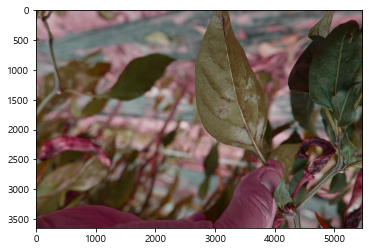

In [47]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)